In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [ ]:
!wget https://raw.githubusercontent.com/jleinonen/ikea-names/master/data/names.txt

--2024-02-25 10:06:56--  https://raw.githubusercontent.com/jleinonen/ikea-names/master/data/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9691 (9.5K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>]   9.46K  --.-KB/s    in 0s      

2024-02-25 10:06:56 (91.8 MB/s) - ‘names.txt’ saved [9691/9691]



In [ ]:
words = open('names.txt', 'r').read().splitlines()
words[:10]

['ABSORB',
 'ADMETE',
 'AGAM',
 'AGEN',
 'AGNARYD',
 'AGNE',
 'AINA',
 'AKSDAL',
 'AKURUM',
 'AKUT']

In [ ]:
len(words)

1361

In [ ]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
itos

{1: 'A',
 2: 'B',
 3: 'C',
 4: 'D',
 5: 'E',
 6: 'F',
 7: 'G',
 8: 'H',
 9: 'I',
 10: 'J',
 11: 'K',
 12: 'L',
 13: 'M',
 14: 'N',
 15: 'O',
 16: 'P',
 17: 'R',
 18: 'S',
 19: 'T',
 20: 'U',
 21: 'V',
 22: 'W',
 23: 'X',
 24: 'Y',
 25: 'Z',
 26: 'Ä',
 27: 'Å',
 28: 'Ö',
 0: '.'}

In [ ]:
len(itos)

29

In [ ]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([7505, 3]) torch.Size([7505])
torch.Size([941, 3]) torch.Size([941])
torch.Size([938, 3]) torch.Size([938])


In [ ]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((29, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200,29), generator=g)
b2 = torch.randn(29, generator=g)
parameters = [C, W1, b1, W2, b2]

In [ ]:
sum(p.nelement() for p in parameters) # number of parameters in total

12319

In [ ]:
for p in parameters:
  p.requires_grad = True

In [ ]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [ ]:
lri = []
lossi = []
stepi = []

In [ ]:
for i in range(200000):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (29,))

  # forward pass
  emb = C[Xtr[ix]] # (29, 3, 2)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (29, 100)
  logits = h @ W2 + b2 # (29, 29)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())


In [ ]:
print(loss.item())

4.614789009094238


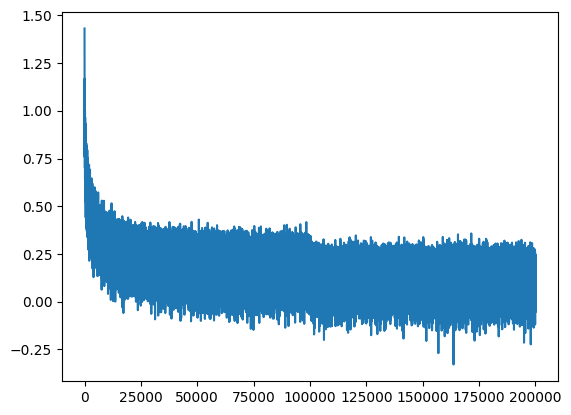

In [ ]:
plt.plot(stepi, lossi)

In [ ]:
# training loss
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 59)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(1.3468, grad_fn=<NllLossBackward0>)

In [ ]:
# validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(4.3242, grad_fn=<NllLossBackward0>)

In [ ]:
# test loss
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(4.6148, grad_fn=<NllLossBackward0>)

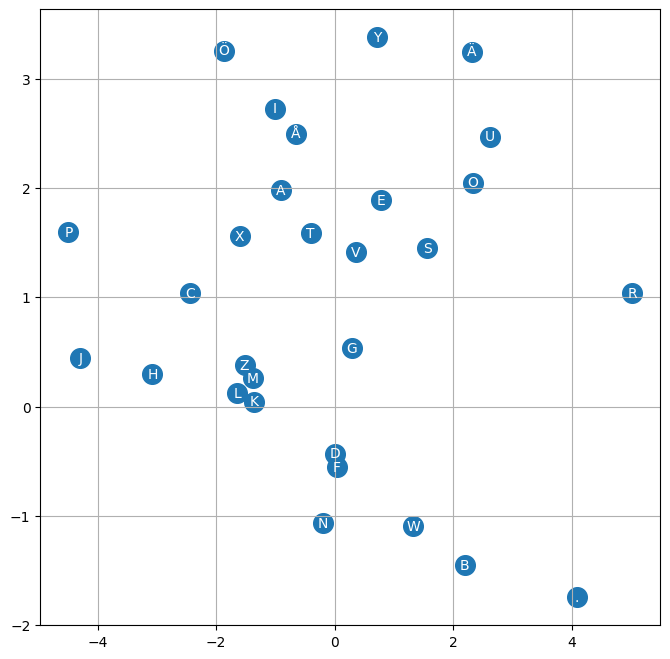

In [ ]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(50):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

MUSIG.
MYSA.
SÄVERN.
HERA.
KRÄMART.
BJURNA.
SORTER.
GULIUS.
MINNEN.
EKTIG.
RUSIGNUM.
LEKMALVE.
FILTANJ.
STYCKHEMMER.
KLOBAL.
ROTER.
VIST.
BÄSTVEIT.
GROLLMMRT.
KASTRIVSTAD.
TERA.
FANTANTIFONNES.
KRONES.
FLÄTTVILAREN.
POÄNG.
FROSORBO.
GRIKSLUTT.
VERTBY.
MÖRSIKTIG.
ISK.
LEN.
KNAS.
ANORDANÖ.
BURKE.
KILA.
BLANDRUP.
BLOM.
LIA.
ENGAN.
FREDRIK.
ANNE.
HÅVAN.
EKÅS.
GUNILLÅKER.
KRABAL.
DOCKE.
HJARESANELIAS.
SPRAKA.
INGSKÄRNUFT.
JULESANDRAGOLF.
